<a href="https://colab.research.google.com/github/bhaveshkumar80/Bangalore-Home-Prices-Estimation/blob/master/LMS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import math
import pytz

from scipy.stats import norm
from datetime import timedelta, datetime

from warnings import filterwarnings
filterwarnings('ignore')

In [37]:
def Load_management_system(df, total_range, date=None, Accuracy=False):

  def date_changer(date):

    '''Change string date to datetime formate for easy access'''
    if date is None:
      date = datetime.today()
    else:
      date = date.split('/')
      date = datetime(int(date[2]), int(date[1]), int(date[0]))
    return date

  def Data_Preprocessing(df):
    '''
      It convert data into linear transformation for model training
    '''
    last_date = df['Date'].to_list()[-1]
    first_date = df['Date'][0]
    num_of_days = last_date - first_date 

    ldf = pd.DataFrame(columns=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    dates = []
    week_dict = {'Sun': 0, 'Mon': 0, 'Tue': 0, 'Wed': 0, 'Thu': 0, 'Fri': 0, 'Sat': 0}
    full_charge_dates = df['Date'][df['Full Charge'] == 1]
    for i in (first_date + timedelta(n) for n in range(num_of_days.days+1)):
      week_dict[i.strftime('%a')] += 1
      if i in df['Date'][df['Full Charge'] == 1].values:
        dates.append(i)
        ldf = ldf.append(week_dict, ignore_index=True)
        week_dict = {'Sun': 0, 'Mon': 0, 'Tue': 0, 'Wed': 0, 'Thu': 0, 'Fri': 0, 'Sat': 0}

    ldf['Date'] = dates

    km_driven = []
    add = 0
    for ra, fc in zip(df['Range Added'].values, df['Full Charge'].values):
      add += ra
      if fc == 1:
        km_driven.append(add)
        add = 0

    ldf['km_driven'] = km_driven
    ldf = ldf[1:]
    return ldf

  def Model_for_less_data(ldf, y_test):
    ''' Divide km_driven into equal part of days driven'''
    df = ldf.drop('Date', axis=1)
    add = 0
    for col in df.columns[:-1]:
      add += df[col].sum()

    each_day = df['km_driven'].sum() / add

    driven_distance = sum(y_test) * each_day
    return driven_distance
  
  def model_training(dff):
    ''' Ridge regresson model'''
    X = dff.drop(['Date', 'km_driven'], axis=1)
    y = dff['km_driven']

    model = Ridge(alpha=0.2)
    model.fit(X, y)

    return model

  def Linear_Transformation(last_date, new_date):

    ''' Linear Transformation for test data'''

    print(f'Last plugged in date: {last_date.strftime("%d-%m-%Y")}, Weekday: {last_date.strftime("%A")}')

    new_date = date_changer(new_date)
    print(f'\nEstimation on Date: {new_date.strftime("%d-%m-%Y")}, Weekday: {new_date.strftime("%A")}')

    num_of_days = new_date - last_date 
    
    if num_of_days.days >= 0:
      week_dict = {'Sun': 0, 'Mon': 0, 'Tue':0, 'Wed':0, 'Thu':0, 'Fri': 0, 'Sat': 0}

      total_weeks = []
      for d in (last_date + timedelta(n) for n in range(1, num_of_days.days + 1)):
        total_weeks.append(d.strftime('%a'))

      for w in total_weeks:
        week_dict[w] += 1

      y_test = [week_dict['Sun'], week_dict['Mon'], week_dict['Tue'], week_dict['Wed'], week_dict['Thu'],
                week_dict['Fri'], week_dict['Sat']]

      return y_test

    else:
      y_test = [0, 0, 0, 0, 0, 0, 0]
      return y_test

  def model_evalution(model, y_test):

    if max(y_test) > 0:
      driven_distance = model.predict([y_test])[0]
    else:
      driven_distance = 0
    return driven_distance

  def Mean_Std_of_Plugin_Date(df):

    data = df['Range left'].values

    mean = np.mean(data)                                            
    std = np.std(data)

    return mean, std

  def hrs_to_min(x):
    x = str(x).split(':')
    x = int(x[0]) * 60 + int(x[1])
    return x

  def min_to_hrs(m):
    hr = str(m // 60)
    min = str(m % 60)
    if len(min) == 1:
      min = str(0) + min
    return ':'.join([hr, min])

  def Mean_Std_of_Plugin_Time(df, date):

    df['plugin_min'] = df['Plug In'].apply(lambda x: hrs_to_min(x))
    df['plugout_min'] = df['Plug Out'].apply(lambda x: hrs_to_min(x))

    def Plug_time_range(x, y):
      plug_sec = datetime.strptime(y, '%H:%M:%S.%f') - datetime.strptime(x, '%H:%M:%S.%f')
      plug_min = plug_sec.seconds / 60
      return plug_min

    time_mins = []
    for x, y in zip(df['Plug In'], df['Plug Out']):
      time_mins.append(Plug_time_range(x, y))

    df['Plug_time_min'] = time_mins

    date = date_changer(date)
    day = date.strftime('%a')

    # Using each week day for calculating mean and std if any week day not present then average of weekdays and same for weekends 
    if day == 'Mon':
      if 'Mon' in df['DOW'].values:
        weekday_df = df[df['DOW'] == 'Mon']
      else:
        weekday_df = df[~((df['DOW'] == 'Sat') | (df['DOW'] == 'Sun'))]

    if day == 'Tue':
      if 'Tue' in df['DOW'].values:
        weekday_df = df[df['DOW'] == 'Tue']
      else:
        weekday_df = df[~((df['DOW'] == 'Sat') | (df['DOW'] == 'Sun'))]
        
    if day == 'Wed':
      if 'Wed' in df['DOW'].values:
        weekday_df = df[df['DOW'] == 'Wed']
      else:
        weekday_df = df[~((df['DOW'] == 'Sat') | (df['DOW'] == 'Sun'))]

    if day == 'Thu':
      if 'Thu' in df['DOW'].values:
        weekday_df = df[df['DOW'] == 'Thu']
      else:
        weekday_df = df[~((df['DOW'] == 'Sat') | (df['DOW'] == 'Sun'))]

    if day == 'Fri':
      if 'Fri' in df['DOW'].values:
        weekday_df = df[df['DOW'] == 'Fri']
      else:
        weekday_df = df[~((df['DOW'] == 'Sat') | (df['DOW'] == 'Sun'))]

    if day == 'Sat':
      if 'Sat' in df['DOW'].values:
        weekday_df = df[df['DOW'] == 'Sat']
      else:
        if 'Sun' in df['DOW'].values:
          weekday_df = df[df['DOW'] == 'Sun']
        else:
          weekday_df = df[~((df['DOW'] == 'Sat') | (df['DOW'] == 'Sun'))]

    if day == 'Sun':
      if 'Sun' in df['DOW'].values:
        weekday_df = df[df['DOW'] == 'Sun']
      else:
        if 'Sat' in df['DOW'].values:
          weekday_df = df[df['DOW'] == 'Sat']
        else:
          weekday_df = df[~((df['DOW'] == 'Sat') | (df['DOW'] == 'Sun'))]


    plugin_mean = np.mean(weekday_df['plugin_min'])
    plugin_std = np.std(weekday_df['plugin_min'])

    plugout_mean = np.mean(weekday_df['plugout_min'])
    plugout_std = np.std(weekday_df['plugout_min'])

    plug_time_range_mean = np.mean(weekday_df['Plug_time_min'])
    plug_time_range_std = np.std(weekday_df['Plug_time_min'])

    return plugin_mean, plugin_std, plugout_mean, plugout_std, plug_time_range_mean, plug_time_range_std

  km_per_kwh = 6.6
  df['Range Added'] = df['kWh Added'].apply(lambda x: x * km_per_kwh)
  df['DOW'] = df['Date'].apply(lambda x: x.strftime('%a'))
  df['Range left'] = df['Range Added'].apply(lambda x: total_range - x)

  dt1 = time.time()
  ldf = Data_Preprocessing(df)
  dt2 = time.time()
  print(f'Time in Data Preprocessing: {round((dt2 - dt1), 3)}')

  lt1 = time.time()
  last_date = df['Date'].tolist()[-1]
  new_date = date
  y_test = Linear_Transformation(last_date, new_date)

  if ldf.shape[0] > 0:

    sun = [1, 0, 0, 0, 0, 0, 0]
    mon = [0, 1, 0, 0, 0, 0, 0]
    tue = [0, 0, 1, 0, 0, 0, 0]
    wed = [0, 0, 0, 1, 0, 0, 0]
    thu = [0, 0, 0, 0, 1, 0, 0]
    fri = [0, 0, 0, 0, 0, 1, 0]
    sat = [0, 0, 0, 0, 0, 0, 1]

    days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

    if ldf.shape[0] >= 10:
      mt1 = time.time()
      model = model_training(ldf)    # Model to use when we have more data
      mt2 = time.time()
      print(f'Time in Model training: {round((mt2 - mt1), 3)}')

      driven_distance = model_evalution(model, y_test)
    else:
      driven_distance = Model_for_less_data(ldf, y_test)  # model will work on less data
  else:
    print('There is no full charge so LDF is None')
    
  range_left = total_range - driven_distance
  if range_left < 0:
    range_left = 0
  lt2 = time.time()
  print(f"Time in model evaluation: {round((lt2 - lt1), 3)}")

  met1 = time.time()
  range_left_mean, range_left_std = Mean_Std_of_Plugin_Date(df)
  plugin_mean, plugin_std, plugout_mean, plugout_std, plug_time_range_mean, plug_time_range_std = Mean_Std_of_Plugin_Time(df, date)
  met2 = time.time()
  print(f"Time taken in Mean and std calculation : {round((met2 - met1), 2)}")

  msdf = pd.DataFrame({
      'total_range': [total_range],
      'max_threshold': [max(df['Range left'].values)],
      'Range_left': [range_left],
      'Range_left_mean': [range_left_mean],
      'Range_left_std': [range_left_std],
      'Plugin_mean': [plugin_mean],
      'Plugin_std': [plugin_std],
      'Plugout_mean': [plugout_mean],
      'Plugout_std': [plugout_std],
      'plug_time_range_mean': [plug_time_range_mean],
      'plug_time_range_std': [plug_time_range_std]
      })
  
  return msdf, ldf

In [41]:
t1 = time.time()
df = pd.read_excel('/content/drive/MyDrive/Blackcoffer/Load_management_system.xlsx')[:10]
total_range = 400
date = '15/02/2021'         

msdf, ldf = Load_management_system(df, total_range, date, Accuracy=False)
msdf.to_csv('temp_mean_std.csv', index=False)
t2 = time.time()
print(f"\nTotal time taken : {round((t2 - t1), 3)}")

Time in Data Preprocessing: 0.041
Last plugged in date: 13-02-2021, Weekday: Saturday

Estimation on Date: 15-02-2021, Weekday: Monday
Time in model evaluation: 0.003
Time taken in Mean and std calculation : 0.0

Total time taken : 0.089


In [42]:
msdf

,total_range,max_threshold,Range_left,Range_left_mean,Range_left_std,Plugin_mean,Plugin_std,Plugout_mean,Plugout_std,plug_time_range_mean,plug_time_range_std
0,400,191.0,294.5,166.2,13.833293,1041.0,14.0,445.5,16.5,844.925,30.441667


In [9]:
def Model_for_less_data(ldf, y_test):
  df = ldf.drop('Date', axis=1)
  add = 0
  for col in df.columns[:-1]:
    add += df[col].sum()

  each_day = df['km_driven'].sum() / add

  driven_distance = sum(y_test) * each_day
  return driven_distance

Model_for_less_data(ldf, [0, 0, 0, 0, 0, 0, 0])

161.19718309859155

In [ ]:
ldf['km_driven'].sum()

240.0

In [ ]:
(240 + 247 + 260 + 239 + 453 + 239 + 221)/36

52.75

In [44]:
sun = [1, 0, 0, 0, 0, 0, 0]
mon = [0, 1, 0, 0, 0, 0, 0]
tue = [0, 0, 1, 0, 0, 0, 0]
wed = [0, 0, 0, 1, 0, 0, 0]
thu = [0, 0, 0, 0, 1, 0, 0]
fri = [0, 0, 0, 0, 0, 1, 0]
sat = [0, 0, 0, 0, 0, 0, 1]

days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for w,d in zip(days, [sun, mon, tue, wed, thu, fri, sat]):
  pred = Model_for_less_data(ldf, d)
  print(f"{w} : {pred}")

Sun : 52.75
Mon : 52.75
Tue : 52.75
Wed : 52.75
Thu : 52.75
Fri : 52.75
Sat : 52.75


In [24]:
sun = [1, 0, 0, 0, 0, 0, 0]
mon = [0, 1, 0, 0, 0, 0, 0]
tue = [0, 0, 1, 0, 0, 0, 0]
wed = [0, 0, 0, 1, 0, 0, 0]
thu = [0, 0, 0, 0, 1, 0, 0]
fri = [0, 0, 0, 0, 0, 1, 0]
sat = [0, 0, 0, 0, 0, 0, 1]

days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for w,d in zip(days, [sun, mon, tue, wed, thu, fri, sat]):
  val = model.predict([d])[0]
  print(f"{w} : {val}")

Sun : 58.93746927469669
Mon : 58.93746927469659
Tue : 79.72593787558729
Wed : 73.49725457730321
Thu : 91.76961246492404
Fri : 71.79260651294015
Sat : 42.35512608504645


In [21]:
model.predict([[0, 1, 1, 1, 1, 1, 0]])

array([359.61108701])

In [ ]:
def LMS2(msdf, est_time):

  def Plugin_Date_Probability(msdf):
    total_range = msdf['total_range'][0]
    max_threshold = msdf['max_threshold'][0]
    range_left = msdf['Range_left'][0]
    mean = msdf['Range_left_mean'][0]
    std  = msdf['Range_left_std'][0]

    dist = norm(mean, std)

    if range_left < 0:
      range_left = 0
      
    if range_left > max_threshold:                                     
      prob = ((total_range - range_left) / (total_range - max_threshold)) * 0.05    
                                                                          
    else:                                                                                                                            
      prob = 0.05 + (1 - dist.cdf(range_left)) * 0.95

    return prob

  def hrs_to_min(x):
    x = str(x).split(':')
    x = int(x[0]) * 60 + int(x[1])
    return x

  def min_to_hrs(m):
    hr = str(m // 60)
    min = str(m % 60)
    if len(min) == 1:
      min = str(0) + min
    return ':'.join([hr, min])

  def Plugin_time_Probability(est_time, msdf):
    plugin_mean = msdf['Plugin_mean'][0]
    plugin_std = msdf['Plugin_std'][0]
    plugout_mean = msdf['Plugout_mean'][0]
    plugout_std = msdf['Plugout_std'][0]
    plug_time_range_mean = msdf['plug_time_range_mean'][0]
    plug_time_range_std = msdf['plug_time_range_std'][0]

    z_score = (hrs_to_min(est_time) - plugin_mean) / plugin_std 


    if plugin_std == 0:
      plugin_std = 10

    plugin_time_dist = norm(plugin_mean, plugin_std)
    plugout_time_dist = norm(plugout_mean, plugout_std)
    plug_time_range_dist = norm(plug_time_range_mean, plug_time_range_std)

    print(f'Plug Out time Mean for Monday : {min_to_hrs(round(plugout_mean))}')
    print(f'Plug Out time std for Monday : {min_to_hrs(round(plugout_std))}')

    print(f'Plug time range Mean for Monday : {min_to_hrs(round(plug_time_range_mean))}')
    print(f'Plug time range std for Monday : {min_to_hrs(round(plug_time_range_std))}')


    if est_time is None:
      est_time = datetime.utcnow()
      est_time = est_time.replace(tzinfo=pytz.UTC)
      est_time = est_time.astimezone(pytz.timezone('America/New_York'))
      if len(str(est_time.minute)) == 1:
        est_time = str(est_time.hour) + ':0' + str(est_time.minute)
      else:
        est_time = str(est_time.hour) + ':' + str(est_time.minute)
      
    plugin_time_prob = (1 - plugin_time_dist.cdf(hrs_to_min(est_time)))

    return est_time, plugin_time_prob, z_score

  range_left_prob = Plugin_Date_Probability(msdf)
  est_time, plugin_prob, z_score = Plugin_time_Probability(est_time, msdf)

  print(f"\nprobability of plugin (Day wise): {round(range_left_prob*100, 2)} %")

  print(f'\nPlugin time Probability on {est_time} : {round(plugin_prob *100, 2)} %')
  print('z_score : ', z_score)

  return range_left_prob, plugin_prob

In [ ]:
t1 = time.time()
msdf = pd.read_csv('temp_mean_std.csv')
est_time = '18:00'
LMS2(msdf, est_time)
t2 = time.time()
print(f'Time taken : {t2 - t1}')

Plug Out time Mean for Monday : 7:23
Plug Out time std for Monday : 0:21
Plug time range Mean for Monday : 14:21
Plug time range std for Monday : 0:35

probability of plugin (Day wise): 88.8 %

Plugin time Probability on 18:00 : 1.05 %
z_score :  2.3070262507128985
Time taken : 0.021795988082885742


In [ ]:
def Model_Accuracy(ldf):
  X = ldf.drop(['Date', 'km_driven'], axis=1)
  y = ldf['km_driven']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  model = Ridge(alpha=0.2)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  rmse = math.sqrt(mse(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)

  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

  print('Root Mean Squared Error : ', rmse)
  print('Mean Absolute Error : ', mae)
  print('Mean Absolute Percentage Error : ', mape)

In [ ]:
m1 = time.time()
from sklearn.model_selection import train_test_split
Model_Accuracy(ldf)
m2 = time.time()
print(m2 - m1)

Root Mean Squared Error :  4.080148880483806
Mean Absolute Error :  4.04021739602338
Mean Absolute Percentage Error :  1.7120634734515467
0.007743358612060547


In [ ]:
mdf = pd.read_csv('temp_mean_std.csv')
mdf

,Range_left,Plugin_date_mean,Plugin_date_std,Plugin_time_mean,Plugin_time_std
0,286.911368,175.701149,20.633148,1042.733333,56.897178


In [ ]:
sun = [1, 0, 0, 0, 0, 0, 0]
mon = [0, 1, 0, 0, 0, 0, 0]
tue = [0, 0, 1, 0, 0, 0, 0]
wed = [0, 0, 0, 1, 0, 0, 0]
thu = [0, 0, 0, 0, 1, 0, 0]
fri = [0, 0, 0, 0, 0, 1, 0]
sat = [0, 0, 0, 0, 0, 0, 1]

days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for w,d in zip(days, [sun, mon, tue, wed, thu, fri, sat]):
  val = model.predict([d])[0]
  print(f"{w} : {val}")

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Blackcoffer/Load_management_system.xlsx')
df.head()

,Date,Plug In,Plug Out,Full Charge,kWh Added
0,2021-01-05,17:00:05.904000,07:30:08.256000,0,31.666667
1,2021-01-08,16:09:33.323000,08:00:58.655000,1,34.848485
2,2021-01-13,18:00:38.794000,07:26:55.397000,1,36.363636
3,2021-01-18,17:35:24.519000,07:09:54.241000,1,37.424242
4,2021-01-22,16:57:43.110000,08:12:03.347000,1,39.393939


In [ ]:
def hrs_to_min(x):
  x = str(x).split(':')
  x = int(x[0]) * 60 + int(x[1])
  return x

df['Plugout_min'] = df['Plug Out'].apply(lambda x: hrs_to_min(x))
df['Plugin_min'] = df['Plug In'].apply(lambda x: hrs_to_min(x))
df['DOW'] = df['Date'].apply(lambda x: x.strftime('%a'))
df.head()  

,Date,Plug In,Plug Out,Full Charge,kWh Added,Plugout_min,Plugin_min,DOW
0,2021-01-05,17:00:05.904000,07:30:08.256000,0,31.666667,450,1020,Tue
1,2021-01-08,16:09:33.323000,08:00:58.655000,1,34.848485,480,969,Fri
2,2021-01-13,18:00:38.794000,07:26:55.397000,1,36.363636,446,1080,Wed
3,2021-01-18,17:35:24.519000,07:09:54.241000,1,37.424242,429,1055,Mon
4,2021-01-22,16:57:43.110000,08:12:03.347000,1,39.393939,492,1017,Fri


(array([ 6., 12., 34., 21.,  5.,  5.,  2.,  1.,  0.,  1.]),
 array([358. , 392.4, 426.8, 461.2, 495.6, 530. , 564.4, 598.8, 633.2,
        667.6, 702. ]),
 <a list of 10 Patch objects>)

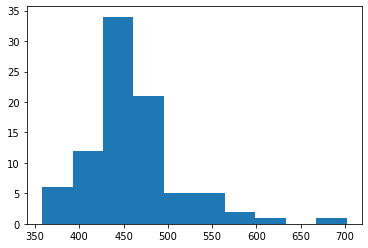

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df['Plugout_min'])

In [ ]:
mean, std = np.mean(df['Plugout_min']), np.std(df['Plugout_min']) 
mean, std

(460.35632183908046, 52.11503125800517)

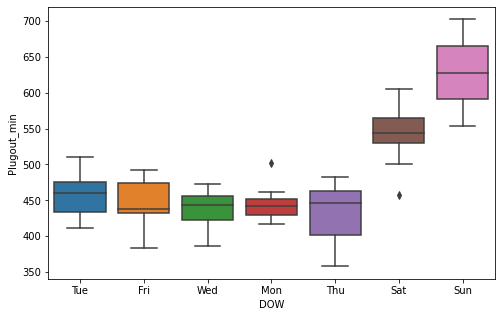

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.boxplot(x = 'DOW', y = 'Plugout_min', data=df)

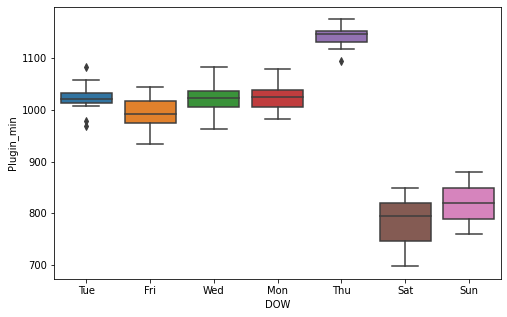

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x = 'DOW', y = 'Plugin_min', data=df)

In [ ]:
def Plug_time_range(x, y):
  plug_sec = datetime.strptime(y, '%H:%M:%S.%f') - datetime.strptime(x, '%H:%M:%S.%f')
  plug_min = plug_sec.seconds / 60
  return plug_min

time_mins = []
for x, y in zip(df['Plug In'], df['Plug Out']):
  time_mins.append(Plug_time_range(x, y))

df['Plug_time_min'] = time_mins

In [ ]:
df.head()

,Date,Plug In,Plug Out,Full Charge,kWh Added,Plugout_min,Plugin_min,DOW,Plug_time_min
0,2021-01-05,17:00:05.904000,07:30:08.256000,0,31.666667,450,1020,Tue,870.033333
1,2021-01-08,16:09:33.323000,08:00:58.655000,1,34.848485,480,969,Fri,951.416667
2,2021-01-13,18:00:38.794000,07:26:55.397000,1,36.363636,446,1080,Wed,806.266667
3,2021-01-18,17:35:24.519000,07:09:54.241000,1,37.424242,429,1055,Mon,814.483333
4,2021-01-22,16:57:43.110000,08:12:03.347000,1,39.393939,492,1017,Fri,914.333333


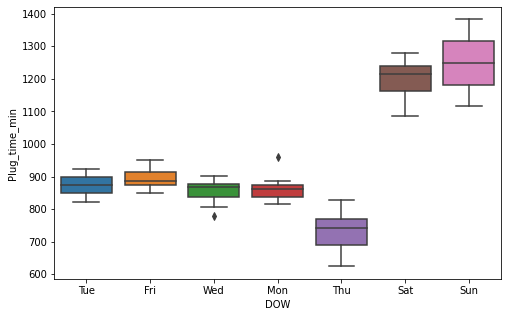

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(df['DOW'], df['Plug_time_min'])

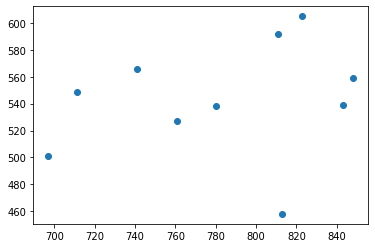

In [ ]:
plt.scatter(df['Plugin_min'][df['DOW'] == 'Sat'], df['Plugout_min'][df['DOW'] == 'Sat'])